In [1]:
import os

import pandas as pd
import torchvision.io
from sklearn.model_selection import train_test_split

os.listdir()

['Mexico_data_preprocessing.ipynb', 'RSNA_data_preprocessing.ipynb']

In [2]:
os.chdir("../")
main_dir = os.getcwd()
main_dir

'D:\\David Mexico\\Bone age estimation\\bone_age_estimation'

In [3]:
age_df = pd.read_csv("data/rsna-bone-age/training/train.csv")
age_df.head()

id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

In [36]:
age_df = preprocessed_df

In [38]:
# Map id to path
age_df['path'] = age_df['id'].map(lambda x: os.path.join(main_dir,
                                                         'data',
                                                         'rsna-bone-age',
                                                         'training',
                                                         'preprocessed',
                                                         '{}.png'.format(x)))

In [39]:
# Checking if all the images exist
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')

# Convert boolean male values to gender 0(male) and 1(female)
age_df['gender'] = age_df['male'].map(lambda x: 0 if x else 1)

5239 images found of 5239 total


In [40]:
boneage_mean = age_df['boneage'].mean()
boneage_div = 2 * age_df['boneage'].std()
# we don't want normalization for now
boneage_mean = 0
boneage_div = 1.0
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x - boneage_mean) / boneage_div)
age_df.dropna(inplace=True)

# Creating bins for the boneage
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)
age_df.sample(3)

id  boneage   male  \
12102  15045      156  False   
10005  12699      144  False   
8527   11040      120  False   

                                                    path  exists  gender  \
12102  D:\David Mexico\Bone age estimation\bone_age_e...    True       1   
10005  D:\David Mexico\Bone age estimation\bone_age_e...    True       1   
8527   D:\David Mexico\Bone age estimation\bone_age_e...    True       1   

       boneage_zscore boneage_category  
12102           156.0   (138.4, 160.8]  
10005           144.0   (138.4, 160.8]  
8527            120.0   (116.0, 138.4]

In [47]:
# Splitting the data into train and validation based on the boneage_category
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)
raw_train_df, valid_df = train_test_split(age_df,
                                          test_size=0.20,
                                          random_state=2018,
                                          stratify=age_df['boneage_category'])
# Saving the dataframe with boneage, path, id and gender information
train_df = raw_train_df[['id', 'boneage', 'path', 'gender']]
validation_df = valid_df[['id', 'boneage', 'path', 'gender']]

In [48]:
# save dataframe not index
train_df.to_csv('data/rsna-bone-age/training/train_preprocessed.csv', index=False)
validation_df.to_csv('data/rsna-bone-age/training/valid_preprocessed.csv', index=False)

In [49]:
len(train_df), len(validation_df)

(4191, 1048)

In [1]:
# Visualizing the data

In [3]:
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [7]:
train_df = pd.read_csv('data/rsna-bone-age/training/train_df.csv')

In [55]:
train_50 = train_df.head(50)
train_3 = train_df.head(3)
train_10 = train_df.head(10)

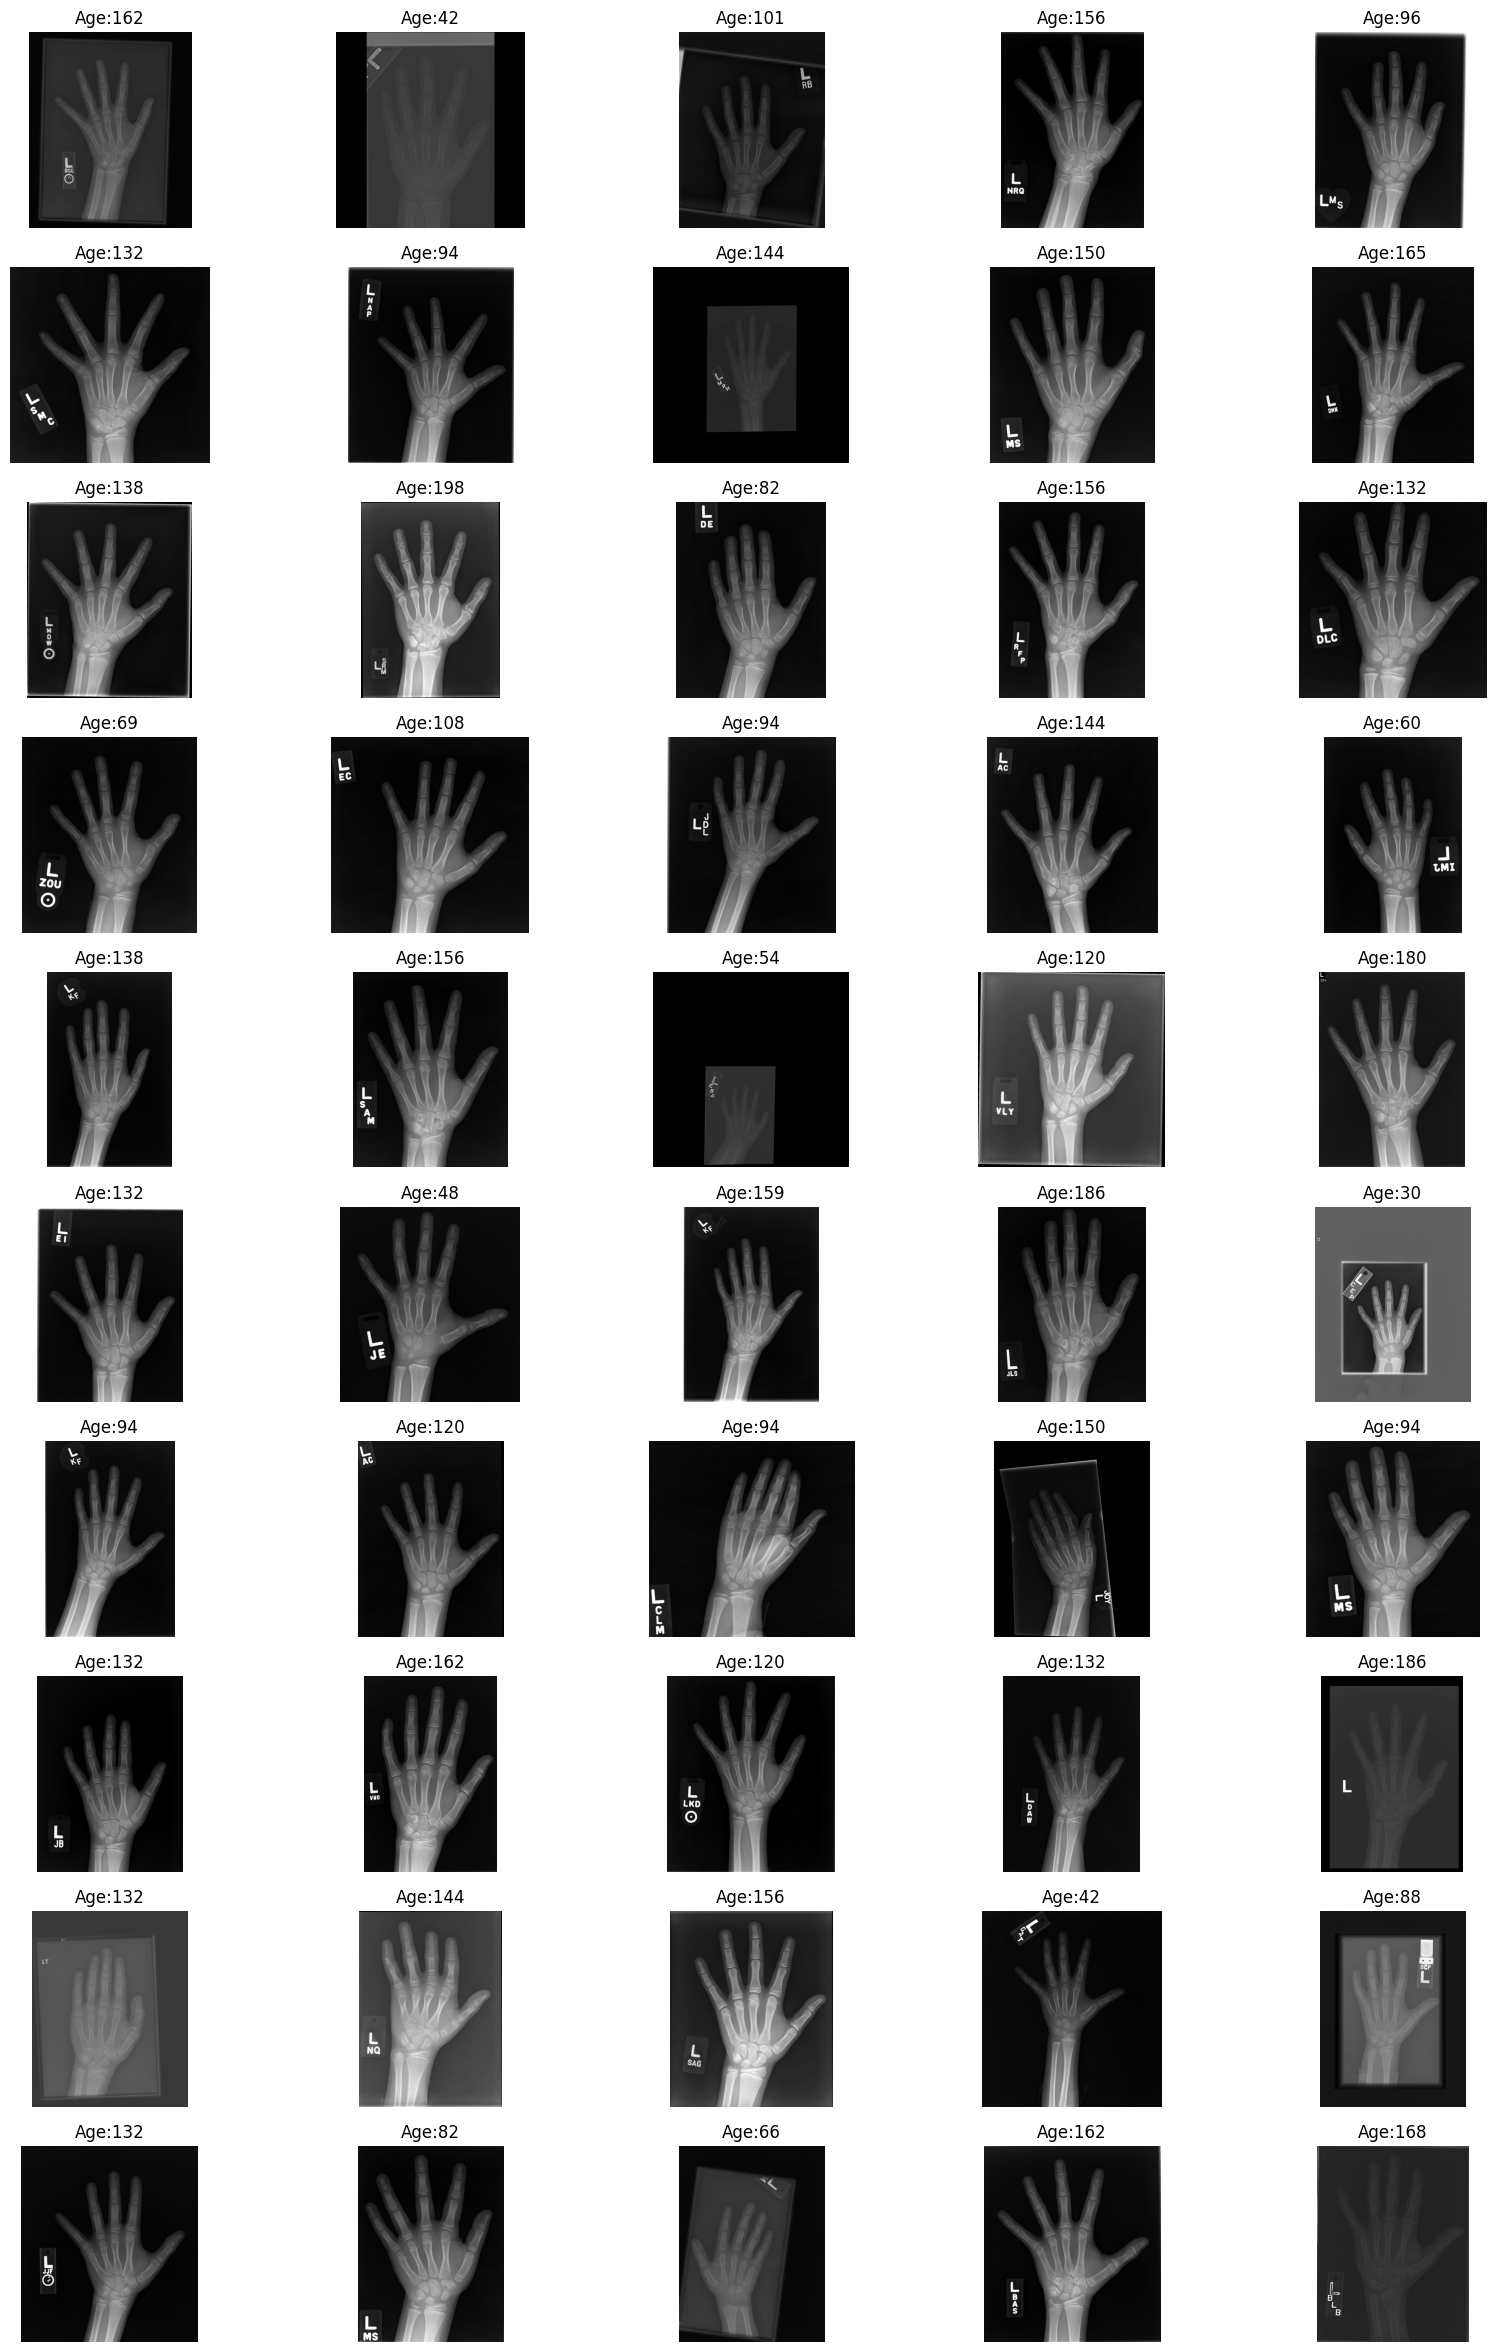

In [18]:
#plot the images using the path column in the train_50 dataframe and plot 4 image per row
row, columns = 10, 5
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
for i, idx in enumerate(train_50.index):
    path = train_50['path'].loc[idx]
    ax[i // columns, i % columns].imshow(plt.imread(path), cmap='gray')
    ax[i // columns, i % columns].axis('off')
    ax[i // columns, i % columns].set_title('Age:{}'.format(train_50['boneage'].loc[idx]))
plt.show()


In [39]:
import torchvision.transforms as transforms
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

# albumentation transformation

transform = A.Compose([
    A.Resize(1024, 1024),
    A.CLAHE(),
    ToTensorV2()
])

In [42]:
for i, idx in enumerate(train_50.index):
    path = train_50['path'].loc[idx]
    # read image and add transformation
    img = cv2.imread(path)
    transformed = transform(image=img)['image']
    # plot both img and transformed side by side
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[1].imshow(transformed.permute(1, 2, 0), cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Transformed Image')
    plt.show()


In [43]:
# clip the scan based on the first and last non-zero pixels
def clip_image(img, plot=False):
    # sum across the rows and columns
    row_sum = np.sum(img, axis=1)
    col_sum = np.sum(img, axis=0)
    # find the first and last non-zero values
    row_first, col_first = np.argmax(row_sum > 0), np.argmax(col_sum > 0)
    row_last, col_last = len(row_sum) - np.argmax(row_sum[::-1] > 0), len(col_sum) - np.argmax(col_sum[::-1] > 0)
    # clip the image
    img = img[row_first:row_last, col_first:col_last]
    if plot:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    return img

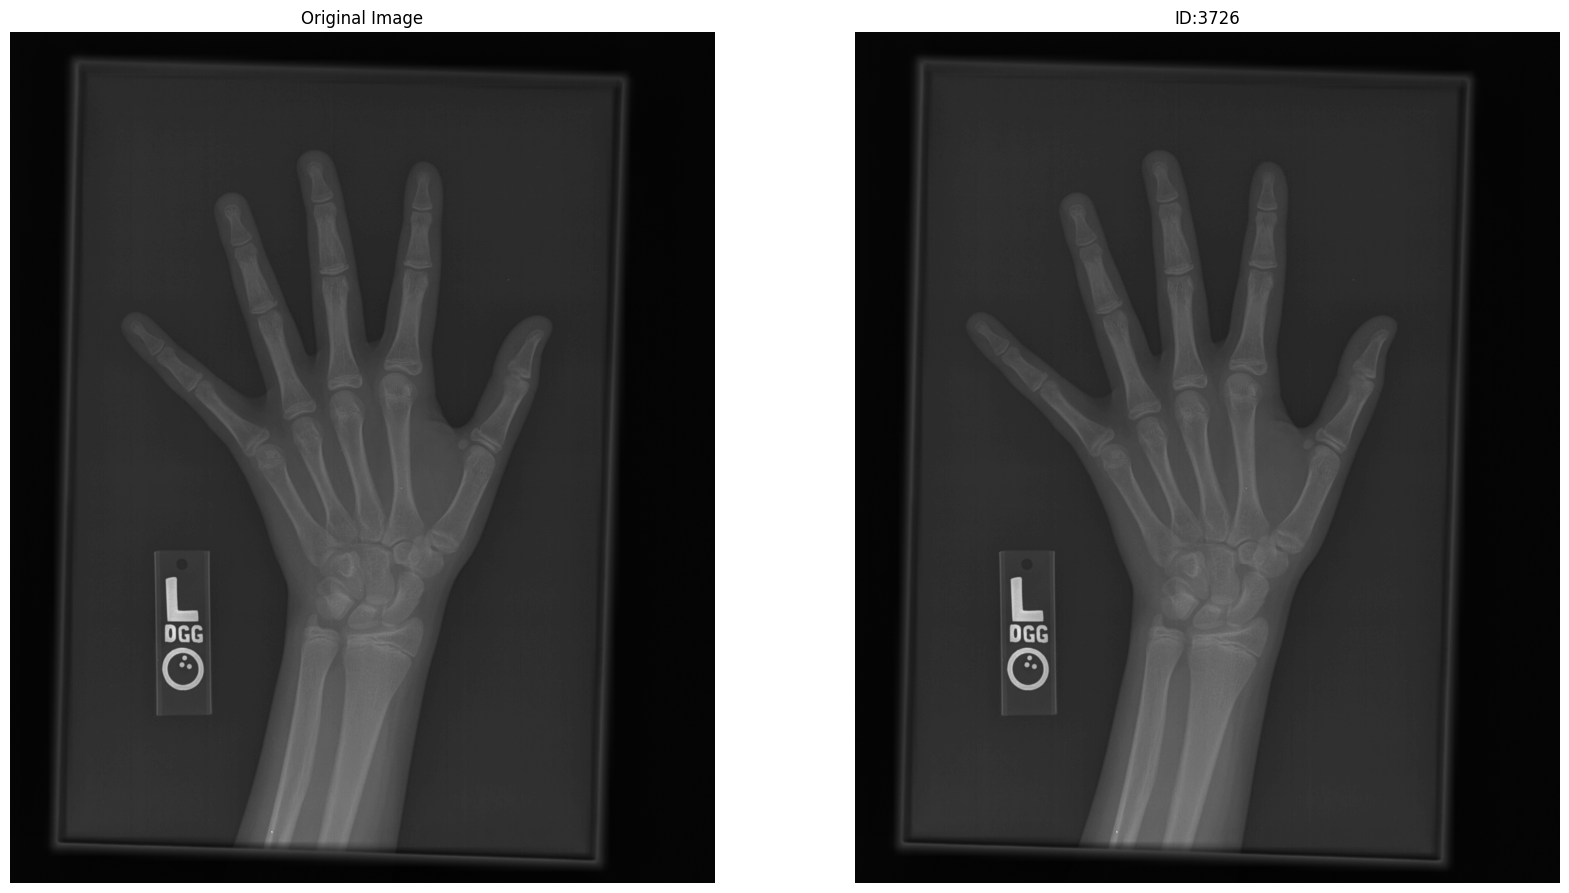

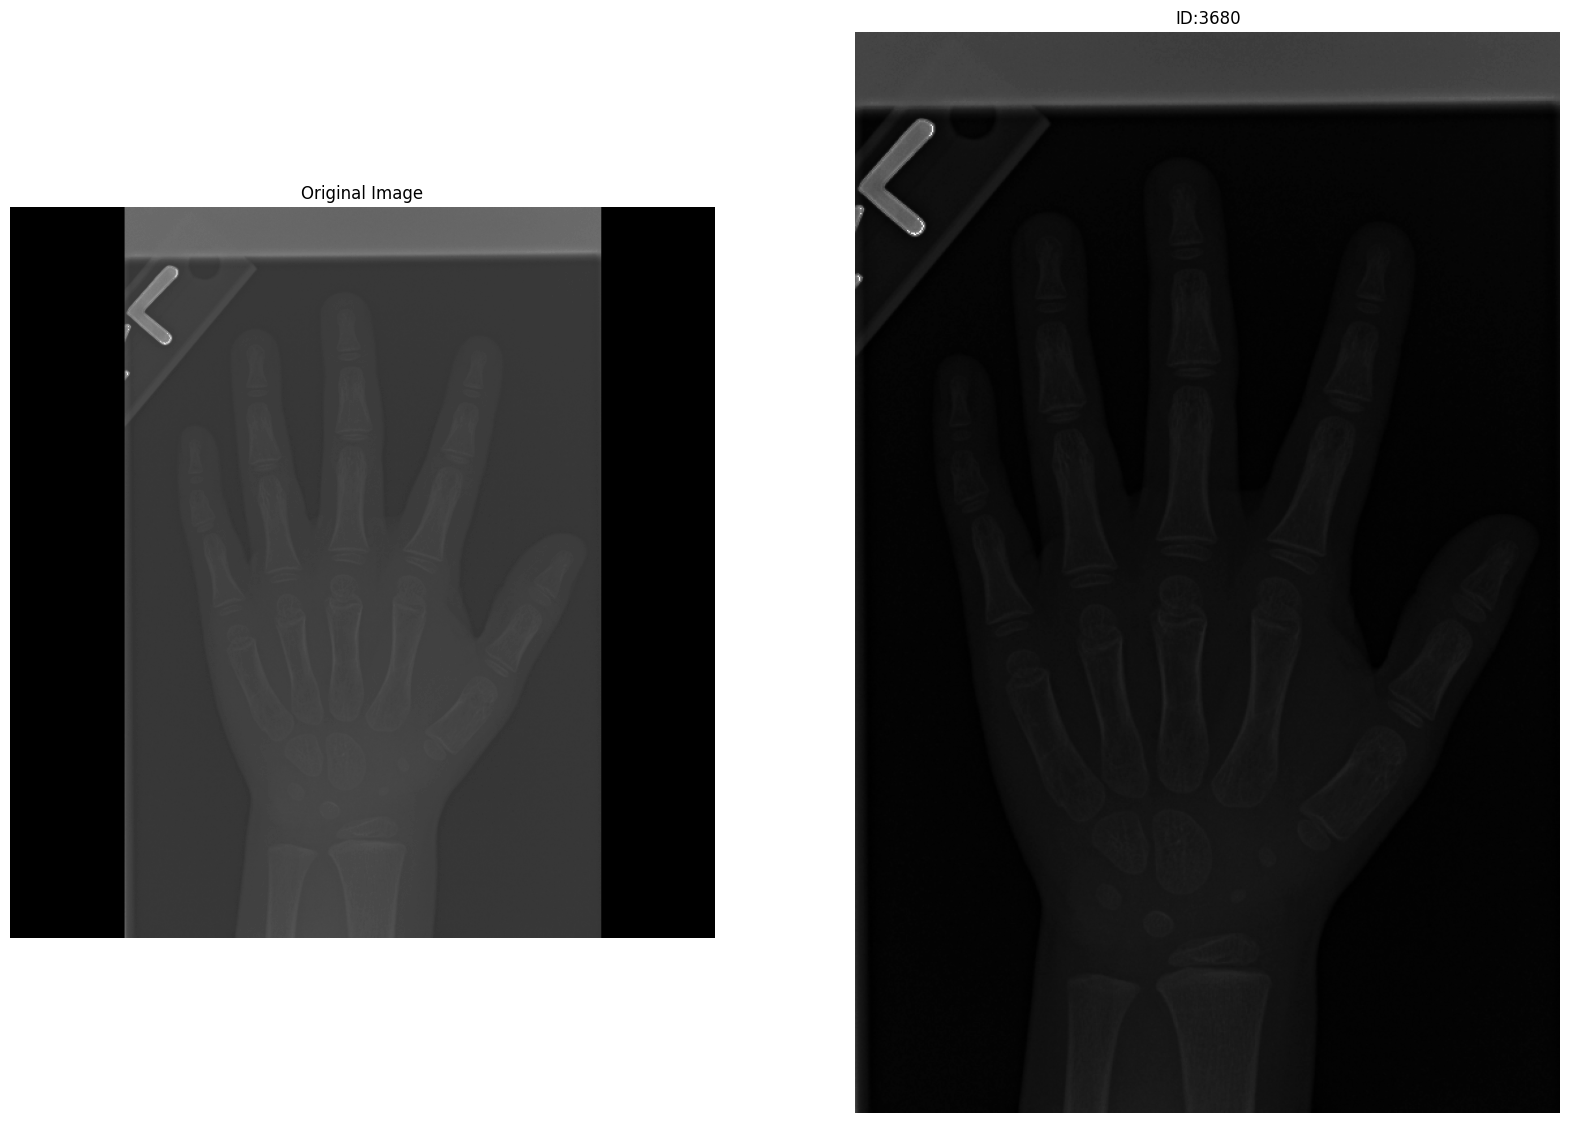

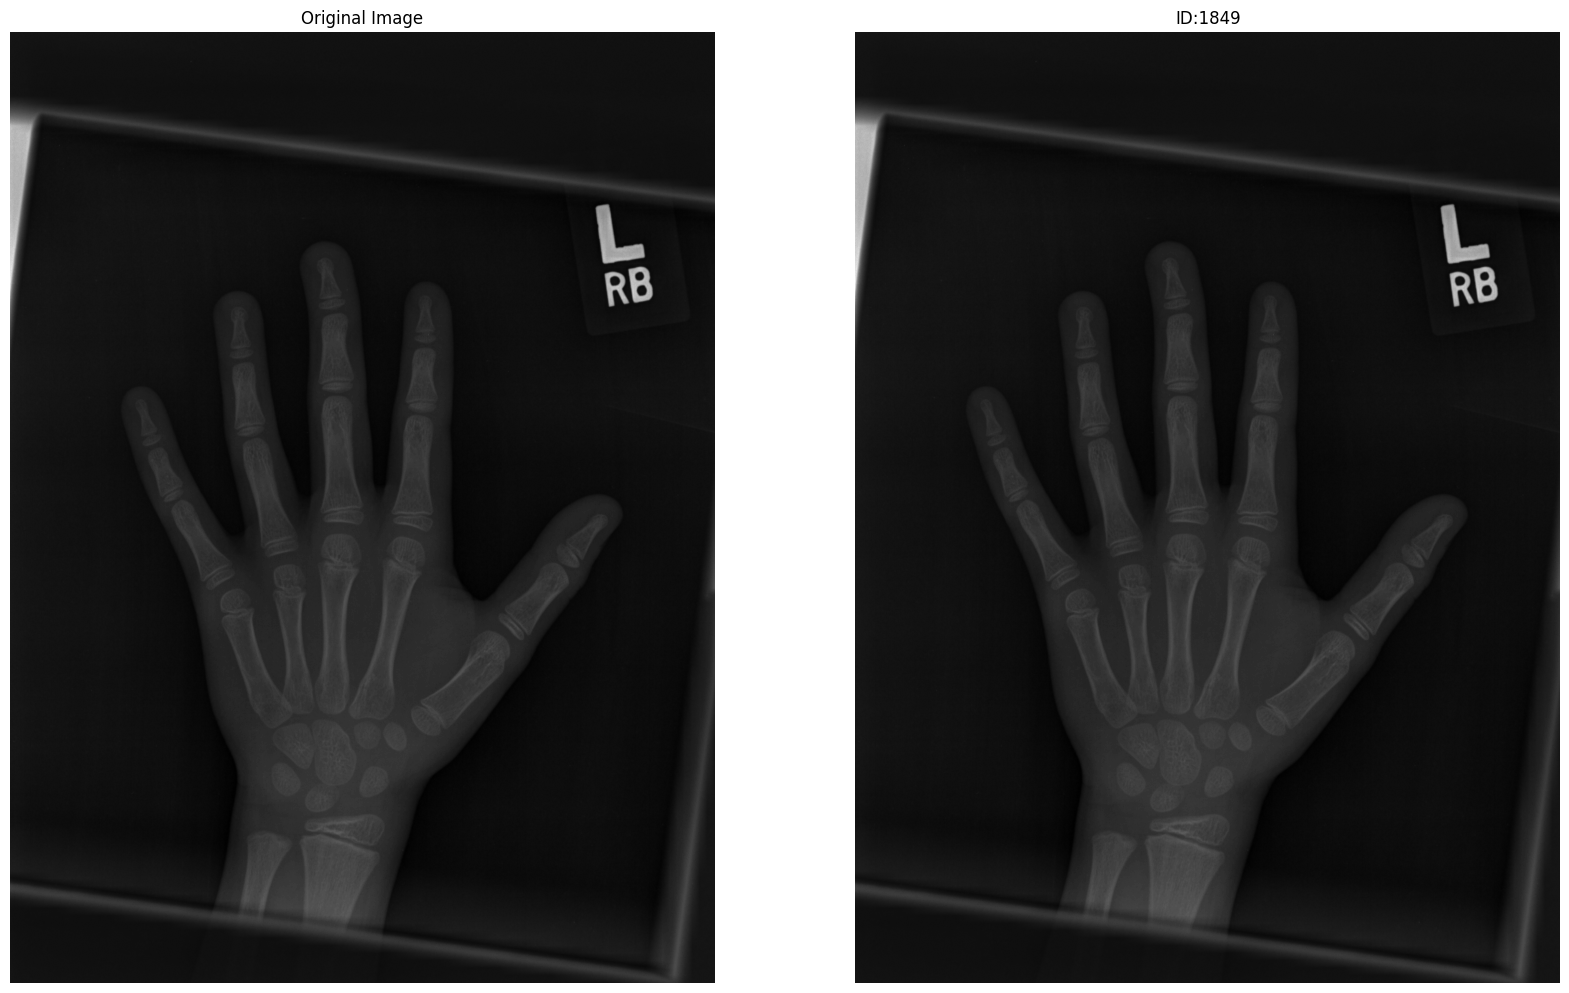

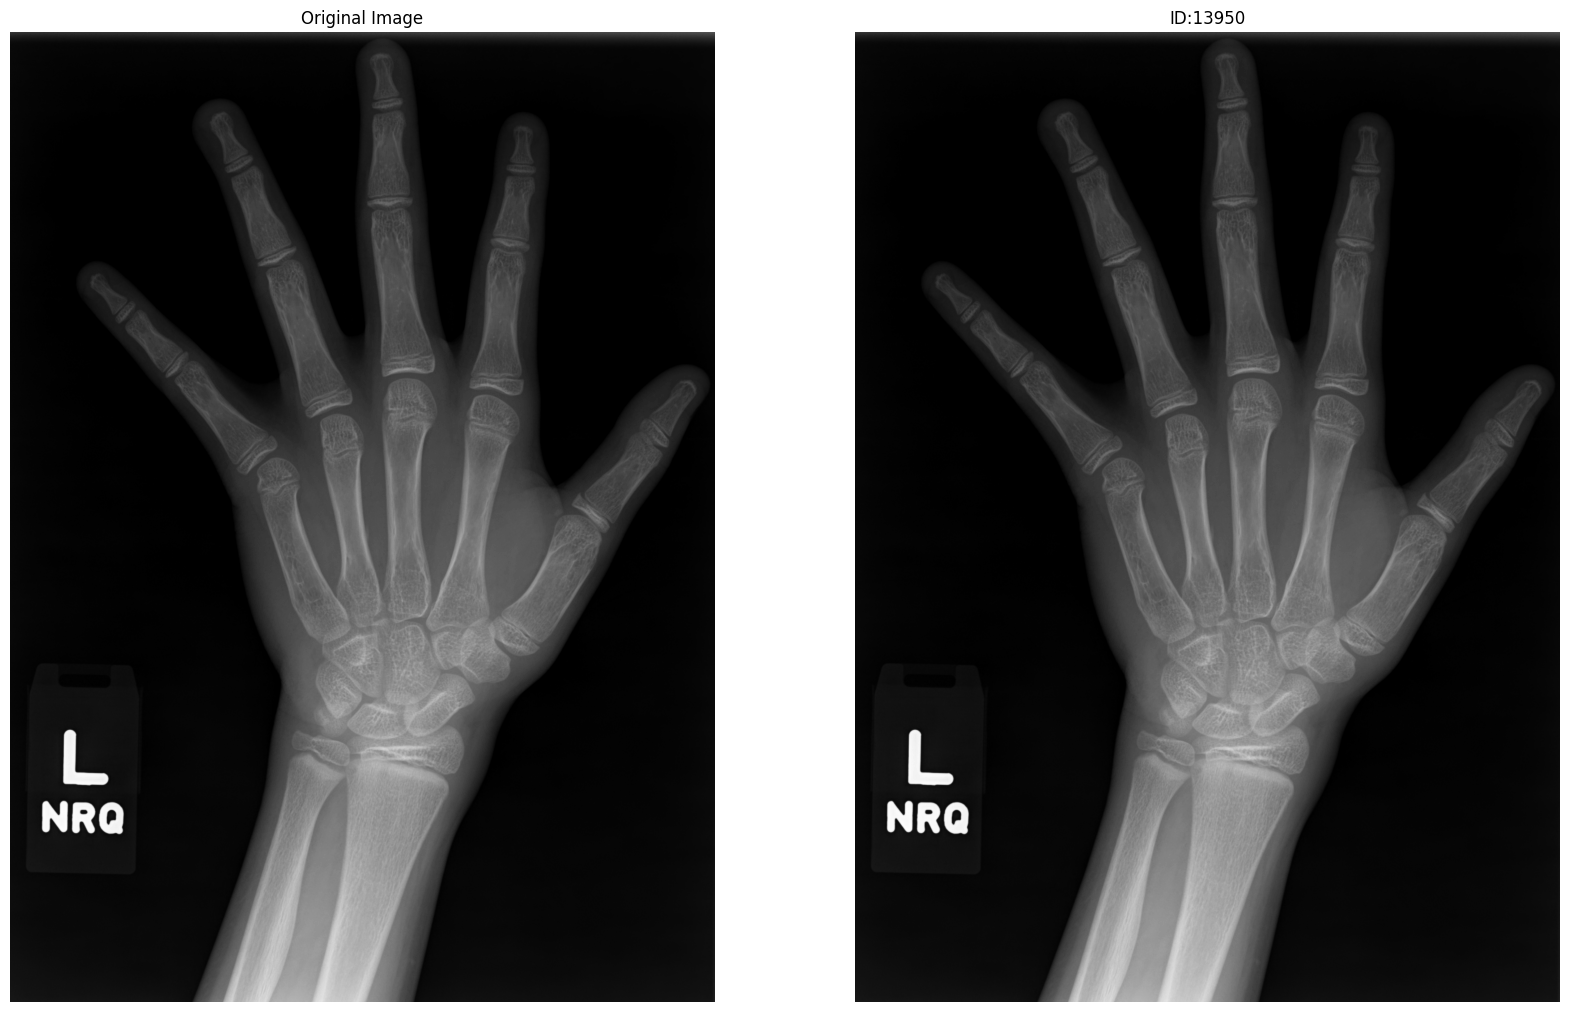

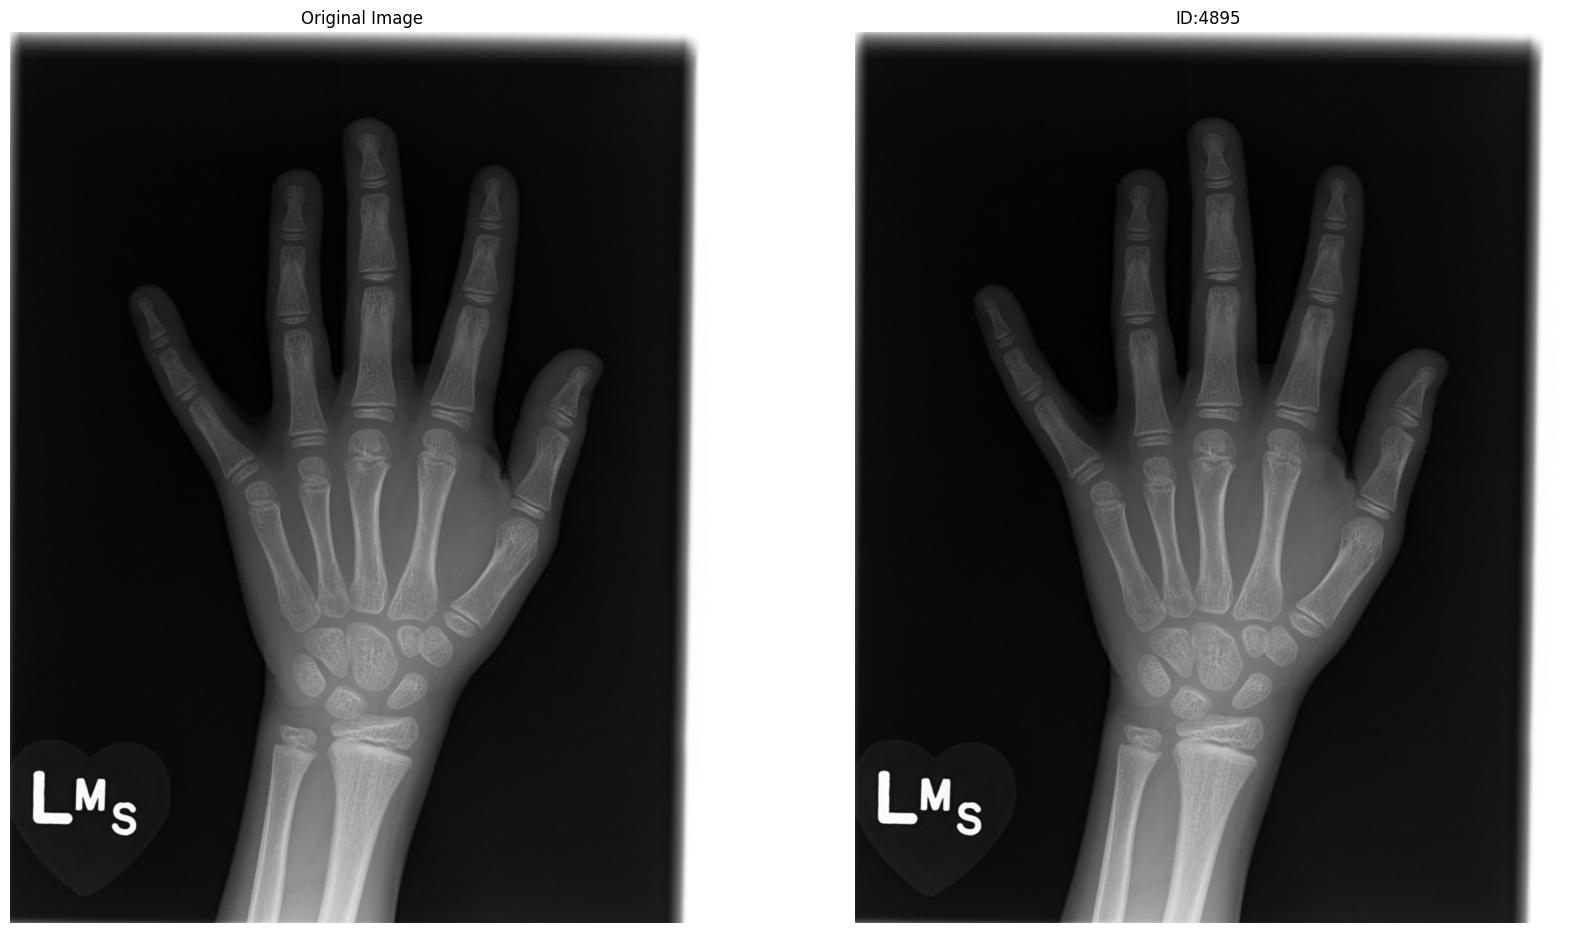

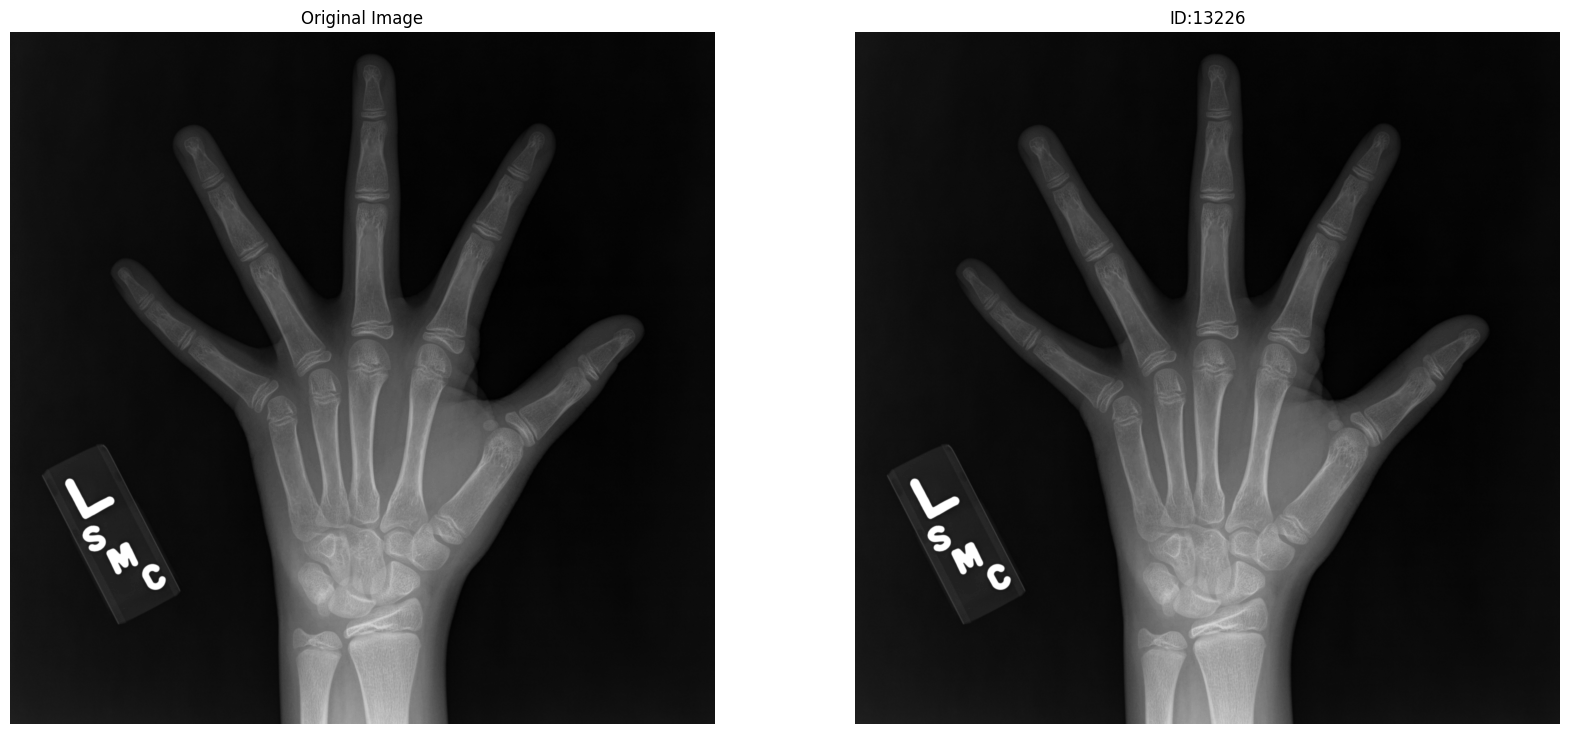

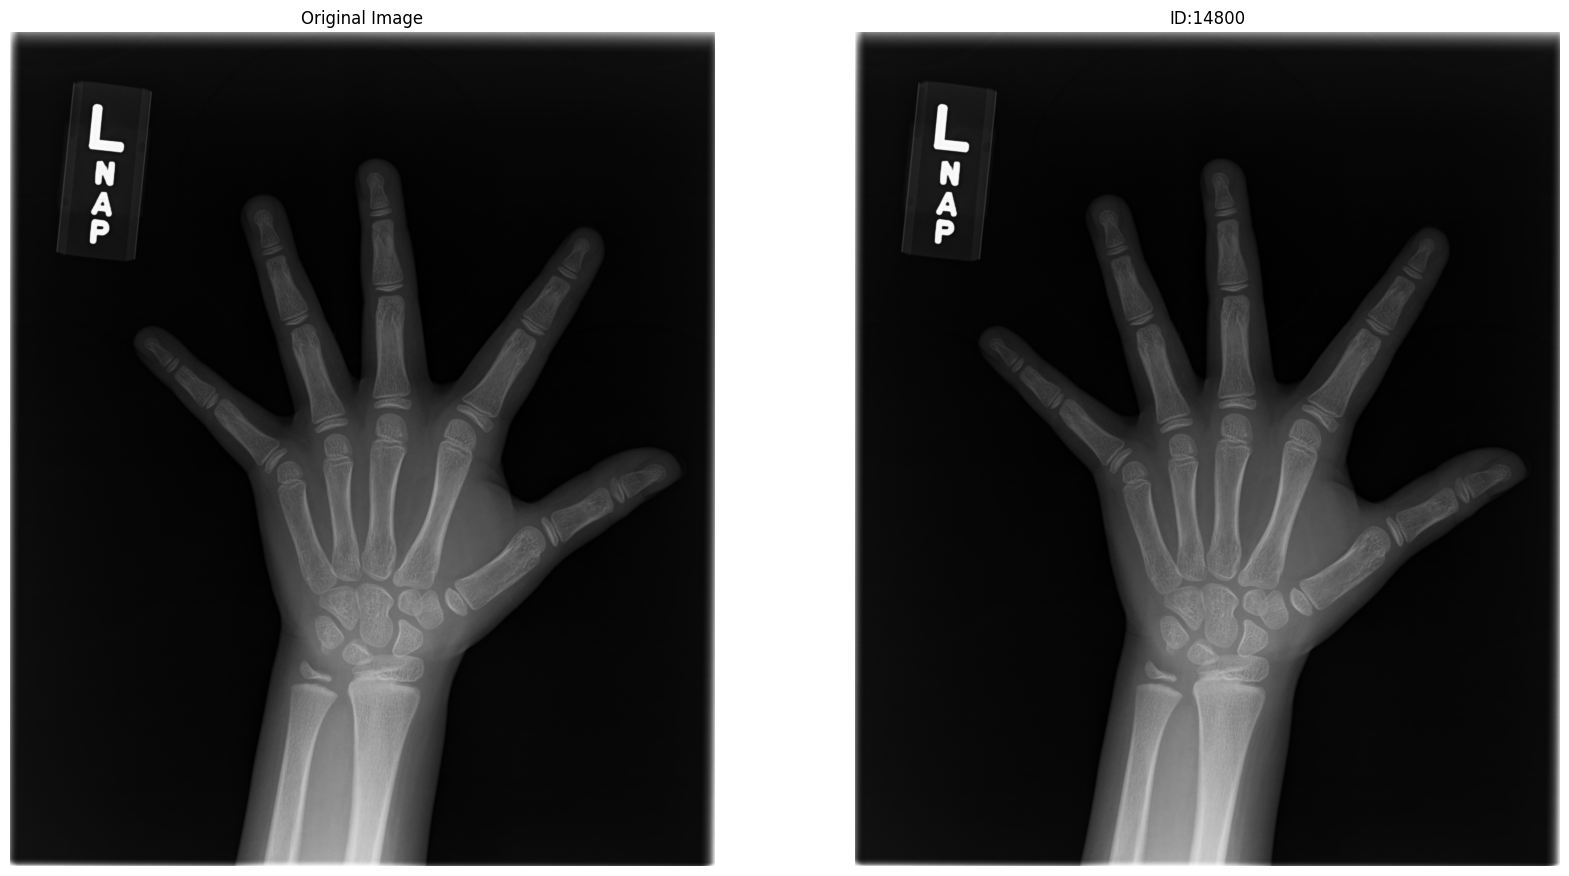

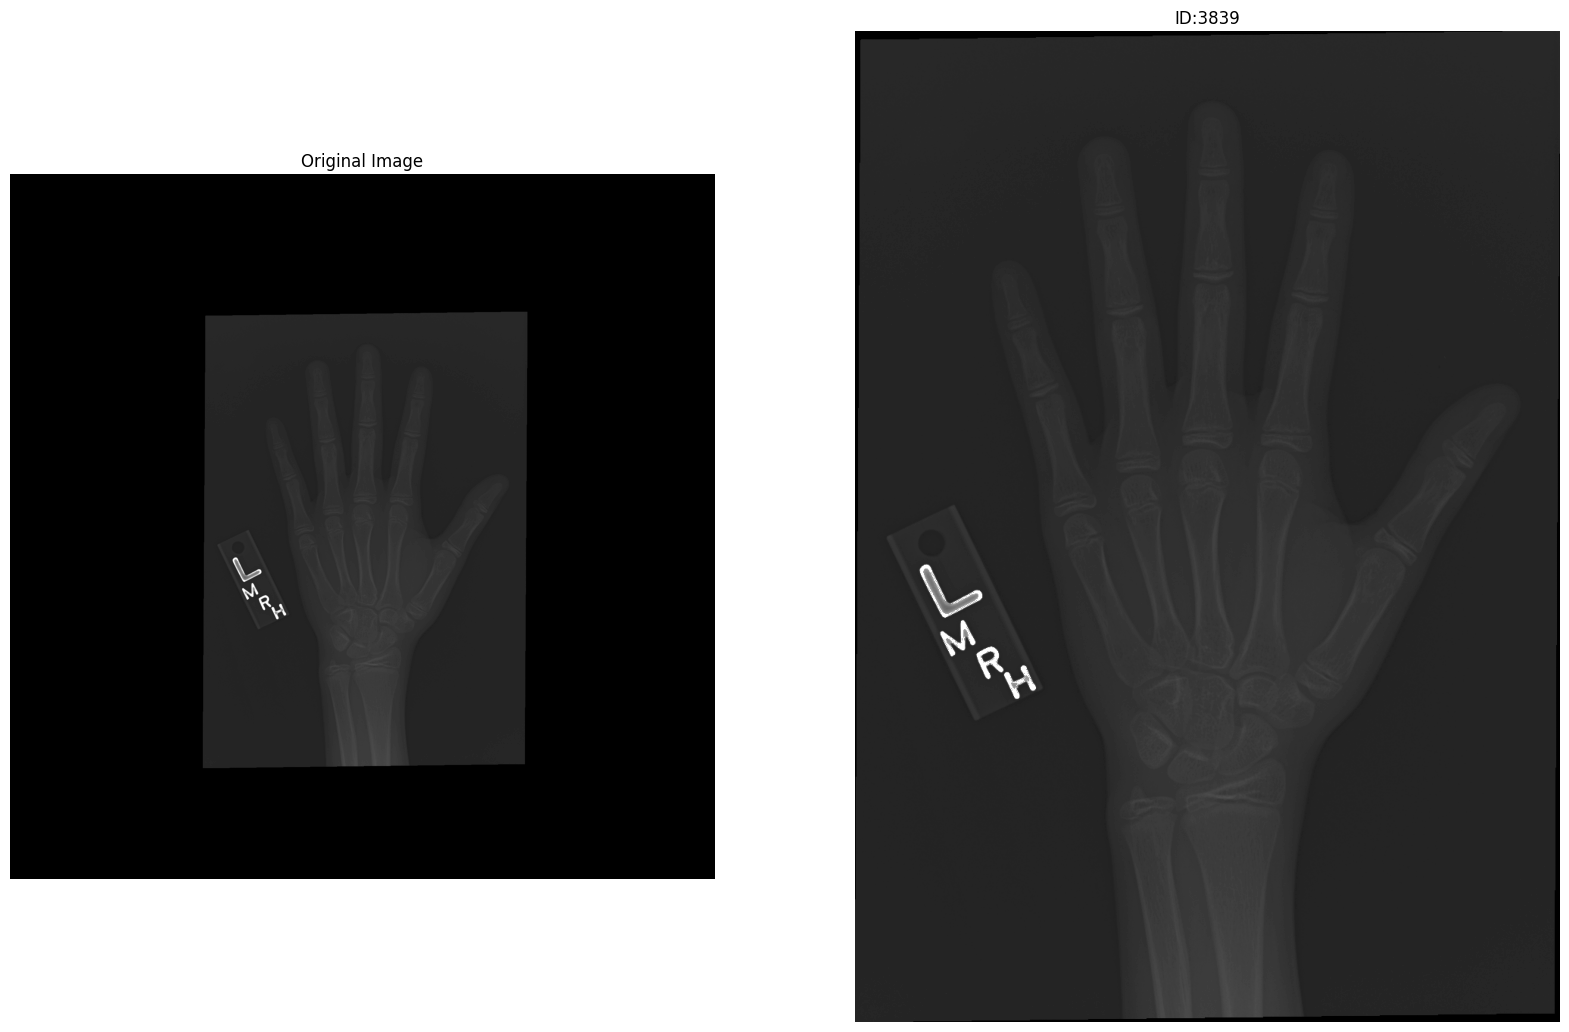

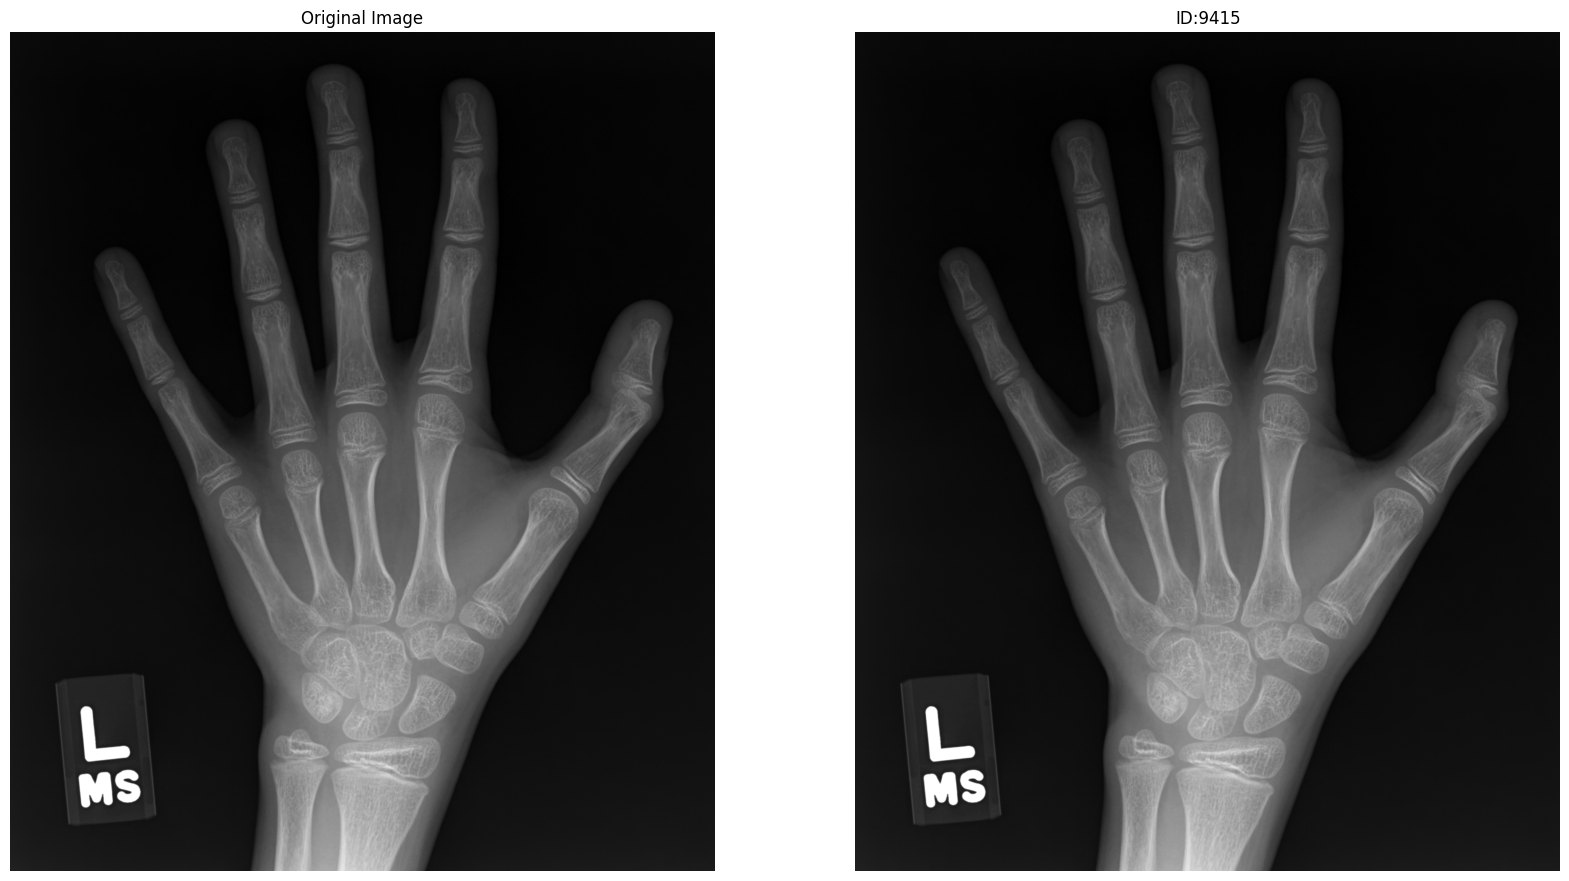

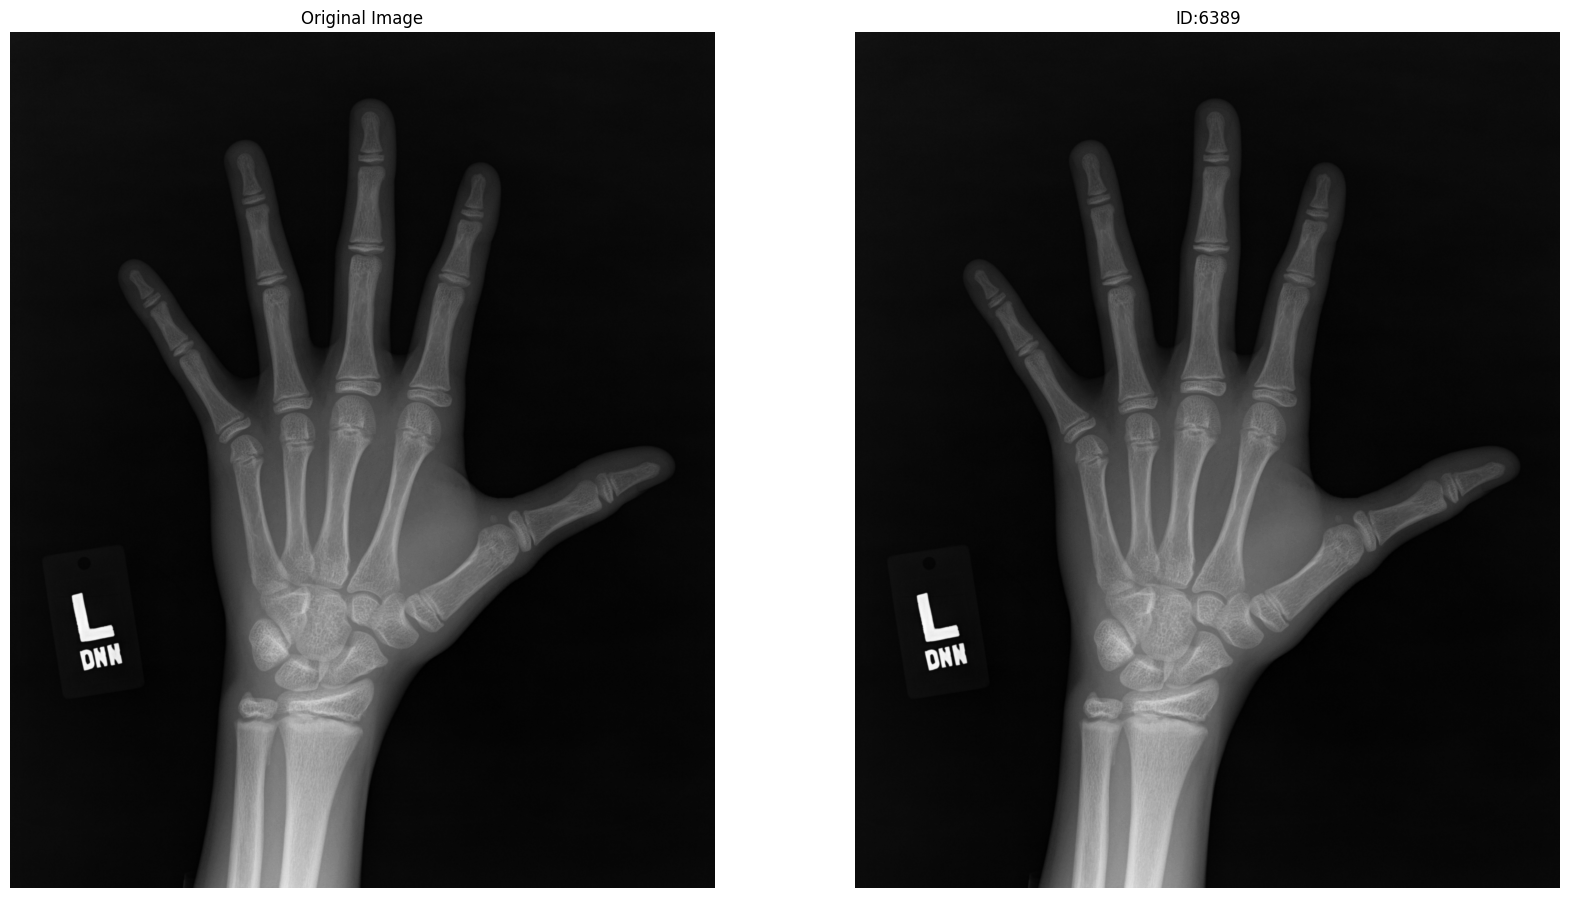

In [57]:
# plot the image before and after clipping
for i, idx in enumerate(train_10.index):
    path = train_10['path'].loc[idx]
    # read image and add transformation
    img = cv2.imread(path, 0)
    clipped = clip_image(img, plot=False)
    # plot both img and transformed side by side
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[1].imshow(clipped, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Clipped Image')
    plt.title('ID:{}'.format(train_10['id'].loc[idx]))
    plt.show()

In [69]:
# histogram equalization and clipping
def equalize_image(img, plot=False):
    # histogram equalization
    img = cv2.equalizeHist(img)
    if plot:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    return img

# plot the intensity histogram and image side by side
def plot_intensity_hist(img):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].hist(img.ravel(), bins=256)
    ax[0].set_title('Intensity Histogram')
    ax[0].set_xlabel('Intensity')
    ax[0].set_ylabel('Count')
    ax[1].imshow(img, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Image')
    plt.show()

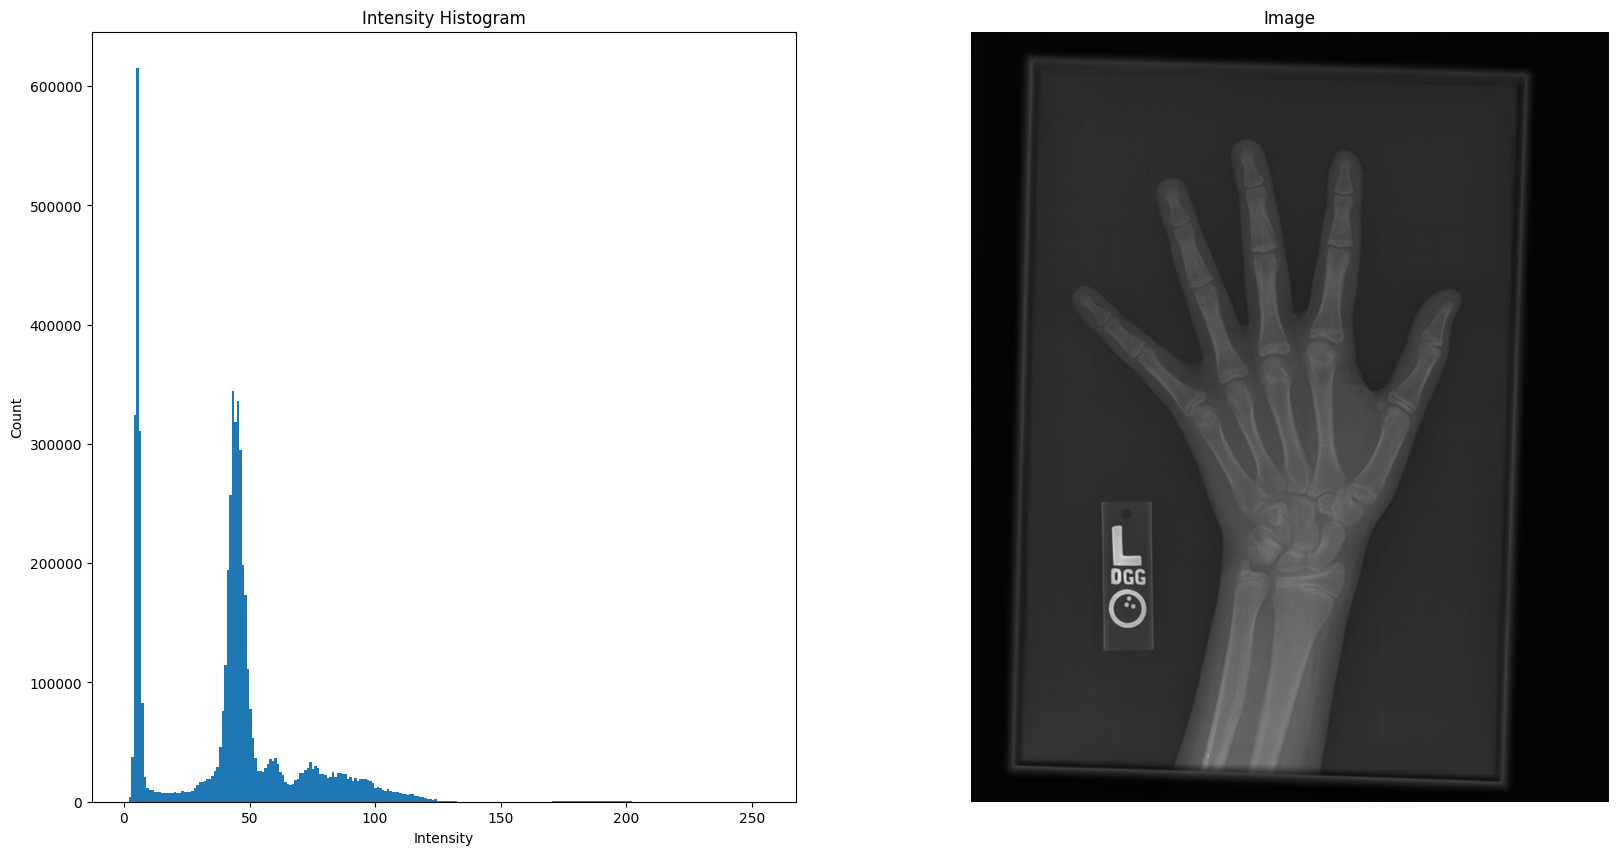

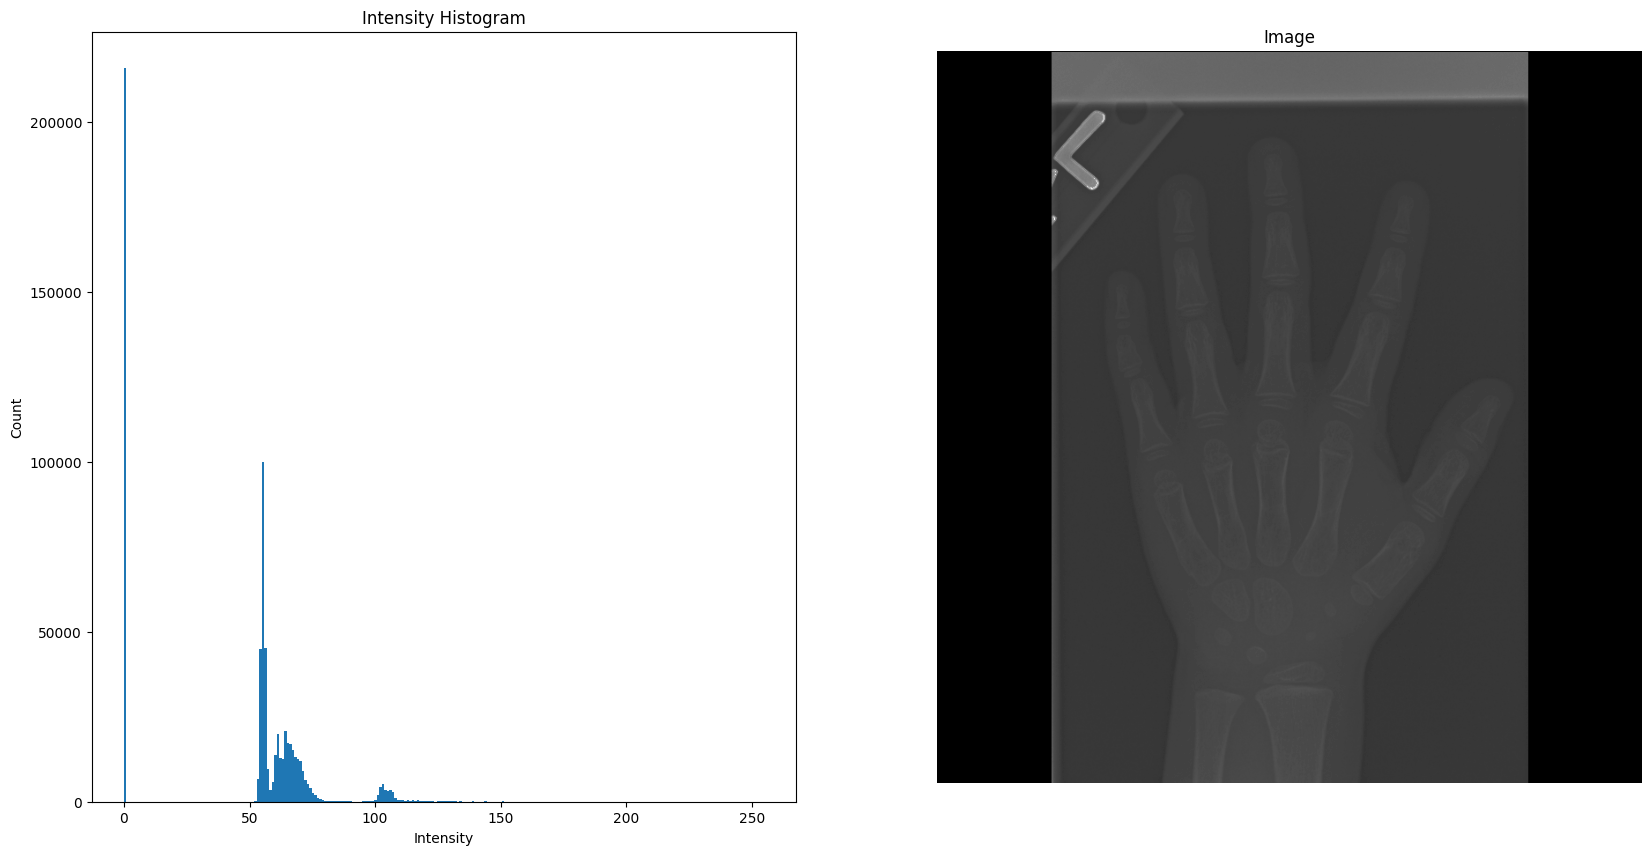

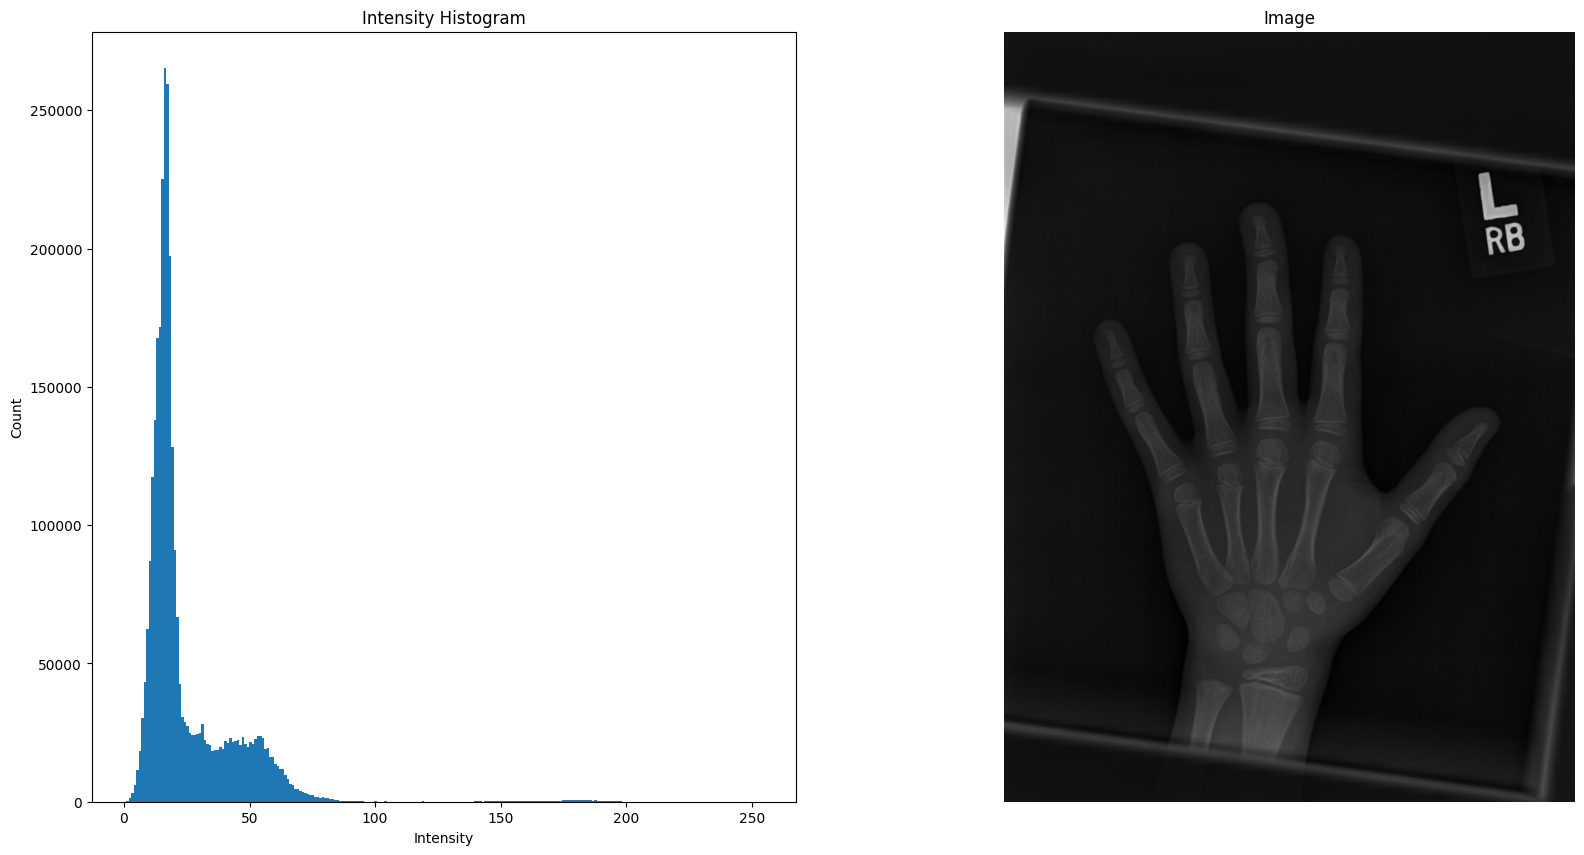

In [70]:
train = train_3
for i, idx in enumerate(train.index):
    path = train['path'].loc[idx]
    # read image and add transformation
    img = cv2.imread(path, 0)
    plot_intensity_hist(img)

# Preprocessed

In [5]:
import glob
import numpy as np
import pandas as pd

In [27]:
age_df = pd.read_csv("data/rsna-bone-age/training/train.csv")
age_df.head()

id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

In [18]:
preprocessed_id = glob.glob("data/rsna-bone-age/training/preprocessed/*.png")

In [30]:
preprocessed_id = [int(os.path.basename(i).split(".")[0]) for i in preprocessed_id]

In [35]:
len(preprocessed_id)

5239

In [32]:
preprocessed_df = age_df.loc[age_df['id'].isin(preprocessed_id)]

In [34]:
len(preprocessed_df)

5239